# Продвинутые темы

Здесь мы рассмотрим несколько концепций, которые являются логическим продолжением основ и часто встречаются в более сложных статистических моделях и алгоритмах машинного обучения, но часто кажущиеся абстрактными: Дельта-метод и Производящую функцию моментов (MGF).

## Дельта-метод: "Эффект домино" в статистике

Представьте себе ряд костяшек домино. Вы толкаете первую костяшку, и она падает. Но вы толкаете ее не всегда одинаково: иногда чуть левее, иногда чуть правее. У этого первого толчка есть **небольшой случайный разброс**.

Последняя костяшка в ряду тоже будет падать с некоторым разбросом. Логично, что ее разброс как-то зависит от разброса вашего первого толчка.

> **Дельта-метод — это способ вычислить "разброс" конечного результата, зная "разброс" начальной причины.**

Это невероятно полезно в статистике.

### Практический пример: Оценка популярности кандидата

Предположим, мы проводим предвыборный опрос.
*   Мы опросили 1000 человек.
*   Из них 550 сказали, что проголосуют за кандидата А.

Наша лучшая оценка популярности кандидата А (обозначим ее $\hat{p}$) — это $550 / 1000 = 0.55$.

Но если бы мы опросили другую тысячу человек, результат был бы немного другим (например, 0.54 или 0.56). У нашей оценки есть **случайный разброс**. Мы можем оценить этот разброс (стандартную ошибку) с помощью статистики.

**А теперь более сложный вопрос:**
Политологи часто используют не саму популярность, а **отношение шансов (odds)**, которое вычисляется как $g(p) = \frac{p}{1-p}$. Для нашего кандидата это $0.55 / (1-0.55) \approx 1.22$. Это означает, что его шансы на победу в 1.22 раза выше, чем на поражение.

**Главный вопрос:** Если мы знаем разброс для нашей оценки популярности $\hat{p}$, как нам найти разброс для оценки шансов?

Именно здесь нам помогает Дельта-метод. Он позволяет "трансформировать" исходный разброс в новый, используя производную (которая, по сути, измеряет "чувствительность" функции к малым изменениям).

Давайте посмотрим на это с помощью симуляции. Мы симулируем 10,000 опросов и посмотрим на разброс оценок популярности и оценок шансов.

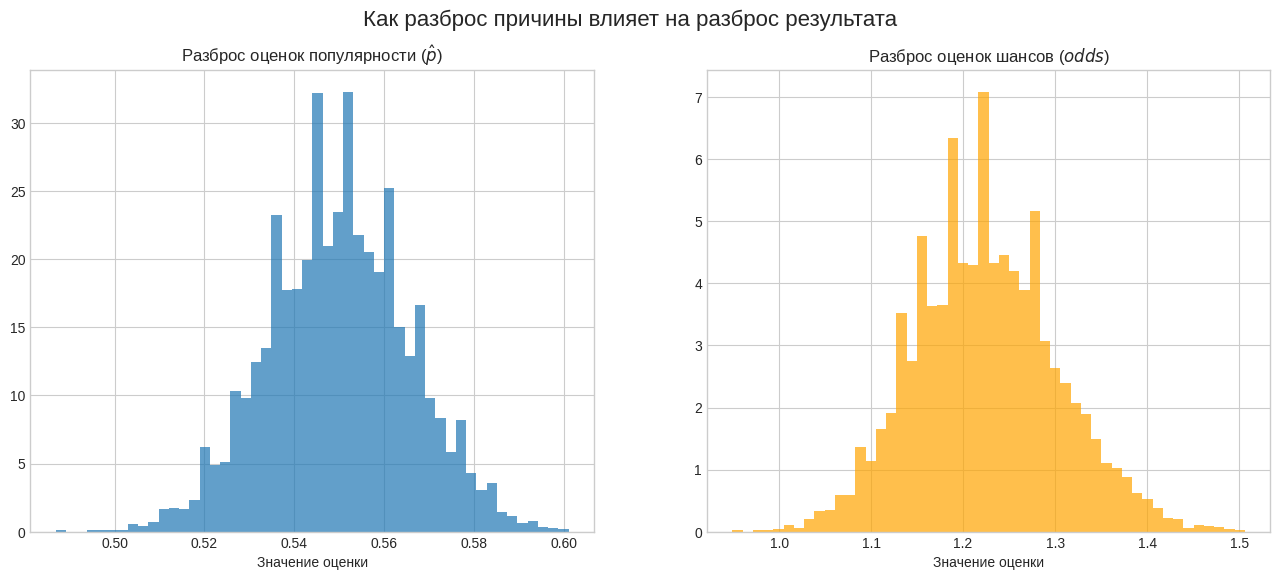

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')

# Параметры нашей симуляции
n_trials = 1000  # 1000 человек в каждом опросе
p_true = 0.55    # Истинная популярность кандидата
n_simulations = 10000 # Проведем 10,000 симуляций опросов

# Проводим симуляции
successes = np.random.binomial(n_trials, p_true, n_simulations)
p_hat_values = successes / n_trials
odds_values = p_hat_values / (1 - p_hat_values)

# Визуализируем оба разброса
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.hist(p_hat_values, bins=50, density=True, alpha=0.7)
ax1.set_title('Разброс оценок популярности ($\hat{p}$)')
ax1.set_xlabel('Значение оценки')

ax2.hist(odds_values, bins=50, density=True, alpha=0.7, color='orange')
ax2.set_title('Разброс оценок шансов ($odds$)')
ax2.set_xlabel('Значение оценки')

plt.suptitle('Как разброс причины влияет на разброс результата', fontsize=16)
plt.show()

Мы видим, что изначальный разброс оценок популярности (слева) породил новый разброс для оценок шансов (справа). Дельта-метод позволяет нам математически вычислить параметры правого графика (его среднее и разброс), зная только параметры левого.

## Производящая функция моментов (MGF): "ДНК" случайности

Представьте, что у каждого вида животных есть уникальный код ДНК. Изучив ДНК, можно узнать всё о животном: какого оно вида и какие у него будут средние характеристики (рост, вес и т.д.).

> **Производящая функция моментов (MGF) — это как уникальный ДНК-код для распределения случайной величины.**

*   У нормального распределения своя MGF, у распределения Пуассона — своя, и они не совпадают.
*   "Расшифровав" MGF (взяв от нее производные), можно получить все важные числовые характеристики распределения: среднее, дисперсию и т.д. (они называются "моментами").

**Но главная суперсила MGF проявляется при сложении независимых случайных величин.**

### Практический пример: Поток покупателей в магазине

Представьте себе большой супермаркет с двумя входами.
*   Через **Вход 1** в среднем заходит 10 покупателей в минуту. Поток покупателей хорошо описывается распределением Пуассона.
*   Через **Вход 2** в среднем заходит 15 покупателей в минуту. Этот поток независим от первого и также описывается распределением Пуассона.

**Вопрос:** Каким будет распределение **общего** числа покупателей, входящих в магазин за минуту?

Интуиция подсказывает, что среднее будет $10 + 15 = 25$. Но будет ли само распределение по-прежнему распределением Пуассона?

MGF дает на этот вопрос элегантный и строгий ответ. Она гласит:
> **"ДНК" суммы = "ДНК" первого * "ДНК" второго**

Математики уже посчитали, что если перемножить "ДНК" двух Пуассоновских распределений, то получится "ДНК" нового Пуассоновского распределения, у которого среднее просто равно сумме исходных средних.

Давайте проверим этот красивый теоретический результат с помощью симуляции. Мы сгенерируем данные для каждого входа и посмотрим на распределение их суммы.

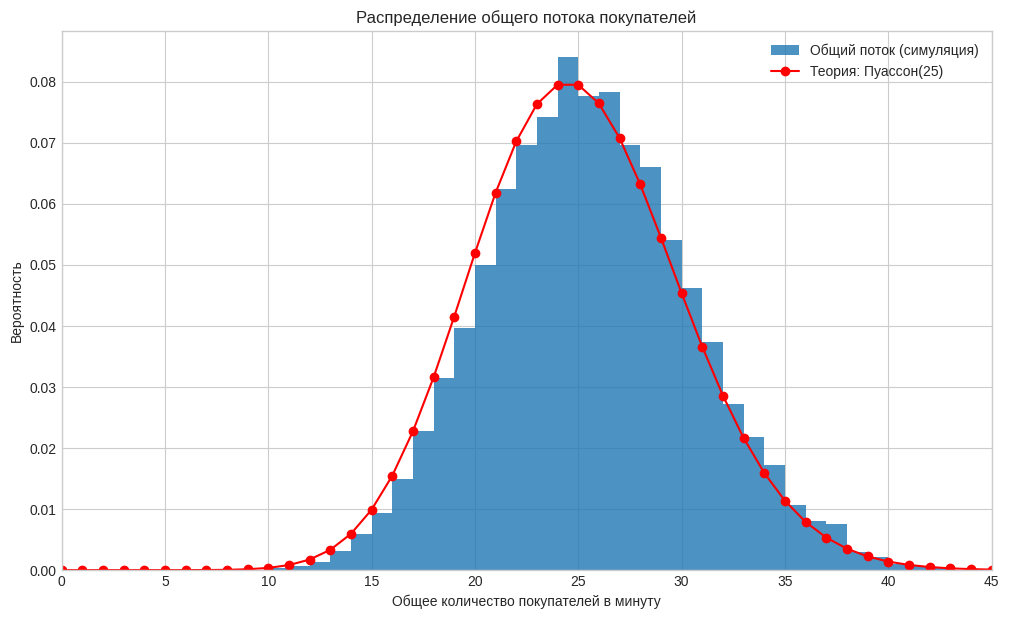

In [17]:
# Параметры
lambda1 = 10  # Среднее для Входа 1
lambda2 = 15  # Среднее для Входа 2
n_minutes = 10000 # Симулируем 10,000 минут работы магазина

# Генерируем случайные данные для каждого входа
buyers_door1 = np.random.poisson(lambda1, n_minutes)
buyers_door2 = np.random.poisson(lambda2, n_minutes)

# Считаем общую сумму для каждой минуты
total_buyers = buyers_door1 + buyers_door2

# --- Визуализация ---
plt.figure(figsize=(12, 7))
# Гистограмма нашей симуляции
plt.hist(total_buyers, bins=range(50), density=True, alpha=0.8, label='Общий поток (симуляция)')

# Теоретический результат: распределение Пуассона со средним 10 + 15 = 25
lambda_total = lambda1 + lambda2
x_values = np.arange(50)
pmf_poisson_total = stats.poisson.pmf(x_values, lambda_total)

# Накладываем теорию на график
plt.plot(x_values, pmf_poisson_total, 'ro-', label=f'Теория: Пуассон({lambda_total})')

plt.title('Распределение общего потока покупателей')
plt.xlabel('Общее количество покупателей в минуту')
plt.ylabel('Вероятность')
plt.legend()
plt.xlim(0, 45)
plt.show()

Результаты симуляции ложатся на теоретическую кривую. Это подтверждает, что сумма двух Пуассоновских процессов — это тоже Пуассоновский процесс. MGF позволяет доказать это без симуляций.